In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


# 📊 Fitbit Activities Analysis

This notebook provides comprehensive analysis of Fitbit activity data including:

- 🏃 **Running & Workout Analysis** - Pace, splits, HR zones, efficiency metrics
- 🏊 **Swimming Analysis** - Lap counting, pace per 100m, pool metrics
- 🚶 **Walking & General Activities** - Distance, duration, calories
- ❤️ **Heart Rate Analysis** - Zone distribution, timeline visualization
- 📈 **Performance Metrics** - Speed, cadence, elevation, GPS tracking

---

## 1. Setup & Configuration

In [13]:
TARGET_DATE = '2025-11-12'  # Date to analyze (YYYY-MM-DD)

# ===== DATA CONFIGURATION =====
PARQUET_PATH = '../data'  # Data directory
TIMEZONE = 'Europe/London'

print(f"Configuration loaded:")
print(f"  Target Date: {TARGET_DATE}")
print(f"  Timezone: {TIMEZONE}")

Configuration loaded:
  Target Date: 2025-11-12
  Timezone: Europe/London


In [14]:
# Import custom functions
from functions.load_data import load_single_date_from_parquet, load_date_range_from_parquet
from functions.performance_functions import (
    plot_full_day_with_workout_highlight,
    plot_multiple_workouts_comparison,
    calculate_hr_zones_from_age,
    DEFAULT_HR_ZONES,
    PLOT_CONFIG
)

---

## 2. Load Data 📥

Load Fitbit data from Parquet files (optimized storage format). Data includes:
- Heart rate measurements (1-second resolution)
- Activity records (runs, swims, walks, etc.)
- Steps data
- Sleep data
- Daily summaries

In [15]:
dfs = load_single_date_from_parquet(TARGET_DATE, PARQUET_PATH, TIMEZONE)
print(f"\n📊 Data Summary for {TARGET_DATE}:")

print("=" * 70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")

print(f"\n✅ Data loaded successfully")


📊 Data Summary for 2025-11-12:
HeartRate_Intraday             |  36955 records
Steps_Intraday                 |   1440 records
SleepLevels                    |     44 records
DeviceBatteryLevel             |      1 records
HR_Zones                       |      1 records
RestingHR                      |      1 records
Activity-distance              |      1 records
HRV                            |      1 records
Activity-calories              |      1 records
Activity-steps                 |      1 records
Activity-minutesVeryActive     |      1 records
Activity-minutesLightlyActive  |      1 records
SPO2_Daily                     |      1 records
SkinTemperature                |      1 records
BreathingRate                  |      1 records
Activity-minutesSedentary      |      1 records
Activity-minutesFairlyActive   |      1 records
SleepSummary                   |      2 records
ActivityRecords                |      3 records

✅ Data loaded successfully


---

## 3. Extract & Convert Activity Data 🔄

**Important:** Fitbit API returns distances in **miles** for all activities. This cell applies automatic conversion to kilometers for consistency and recalculates pace/speed metrics accordingly.

The output below will vary based on analysis mode (single vs multi-day).

In [16]:
df_activity_records = dfs.get('ActivityRecords', pd.DataFrame())
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())

print("=" * 80)
print("ACTIVITY SUMMARY")
print("=" * 80)

if not df_activity_records.empty:
    activity_types = df_activity_records['ActivityName'].value_counts()
    
    print(f"\nFound {len(df_activity_records)} activities across {len(activity_types)} types:\n")
    print(f"{'#':>4} | {'Activity':15s} | {'Duration':>8} | {'Distance':>10} | {'Calories':>8} | {'Avg HR':>8}")
    print("-" * 80)
    
    for idx, row in df_activity_records.sort_values('time').iterrows():
        duration_min = row['duration'] / 1000 / 60 if 'duration' in row else 0
        activity_name = row.get('ActivityName', 'Unknown')
        
        if 'distance' in row and pd.notna(row['distance']) and row['distance'] > 0:
            distance_str = f"{row['distance']:.2f} mi"
        else:
            distance_str = "-"
        
        calories = row.get('calories', 0)
        calories_str = f"{calories:.0f}" if pd.notna(calories) else "-"

        avg_hr = row.get('averageHeartRate', 0)
        avg_hr_str = f"{avg_hr:.0f}" if pd.notna(avg_hr) else "-"
        
        print(f"{idx:>4} | {activity_name:15s} | {duration_min:>5.0f} min | {distance_str:>10} | {calories_str:>8} | {avg_hr_str:>8}")
    
    print("-" * 80)
    total_duration_min = df_activity_records['duration'].sum() / 1000 / 60
    total_distance = df_activity_records['distance'].sum() if 'distance' in df_activity_records else 0
    total_distance_str = f"{total_distance:.2f} mi" if total_distance > 0 else "-"
    print(f"{'':>4} | {'TOTAL':15s} | {total_duration_min:>5.0f} min | {total_distance_str:>10} | {df_activity_records['calories'].sum():>8.0f} | {'':>8}")
else:
    print(f"\n⚠️  No activities found for {TARGET_DATE}")

ACTIVITY SUMMARY

Found 3 activities across 2 types:

   # | Activity        | Duration |   Distance | Calories |   Avg HR
--------------------------------------------------------------------------------
 648 | Walk            |    50 min |    2.51 mi |      367 |       98
 649 | Swim            |    50 min |    1.38 mi |      400 |       92
 650 | Walk            |    26 min |    0.75 mi |      191 |      109
--------------------------------------------------------------------------------
     | TOTAL           |   126 min |    4.65 mi |      958 |         


In [17]:
# if len(df_activity_records) > 0:
#     # Select relevant columns
#     cols_to_show = [
#         'time', 'ActivityName', 'calories', 'distance', 'steps',
#         'speed', 'pace', 'averageHeartRate', 'duration',
#         'elevationGain'
#     ]
    
#     # Filter columns that exist
#     available_cols = [col for col in cols_to_show if col in df_activity_records.columns]
    
#     print("\n📊 Activity Details:")
#     print("="*100)
#     display(df_activity_records[available_cols])
# else:
#     print("ℹ️  Single-day activity table - switch to ANALYSIS_MODE = 'single' to use")

In [18]:
# Use default zones
hr_zones = DEFAULT_HR_ZONES

print("Heart Rate Zones:")
for zone, info in hr_zones.items():
    print(f"  {zone:15s}: {info['range'][0]:3d} - {info['range'][1]:3d} bpm")

Heart Rate Zones:
  Out of Range   :   0 -  97 bpm
  Fat Burn       :  98 - 122 bpm
  Cardio         : 123 - 154 bpm
  Peak           : 155 - 220 bpm


---

## 4. Heart Rate Zones Configuration ❤️

Define heart rate zones for training analysis:
- **Out of Range**: Rest/recovery
- **Fat Burn**: Light cardio, endurance building
- **Cardio**: Moderate intensity, aerobic fitness
- **Peak**: High intensity, anaerobic threshold

In [19]:
# # Plot performance timeline for all activities
# if len(df_activity_records) > 0:
#     for idx, activity in df_activity_records.sort_values('time').iterrows():
#         activity_name = activity.get('ActivityName', 'Unknown')
#         print(f"{'='*60}")
#         print(f"{activity_name} - {activity['time'].strftime('%Y-%m-%d %H:%M')}")
#         print(f"{'='*60}\n")
        
#         try:
#             fig = plot_performance_timeline(
#                 df_hr_intra,
#                 df_steps_intra,
#                 activity,
#                 hr_zones=hr_zones,
#                 timezone='Europe/London'
#             )
#             plt.show()
#         except Exception as e:
#             print(f"⚠️  Error plotting: {e}")
        
#         print()
# else:
#     print("❌ No activities to plot")

---

## 5. Activity Performance Timeline 📈

Detailed view of a single activity showing:
- Heart rate throughout the activity
- Steps/pace progression
- HR zone distribution
- Performance metrics

**Configure:** Change `activity_index` above to select which activity to analyze (0 = first, 1 = second, etc.)

---

## 6. Full Day Context View 📅

Shows the selected activity in the context of your entire day:
- Full 24-hour heart rate timeline
- Activity period highlighted
- See how the workout affects resting HR
- Recovery patterns visible

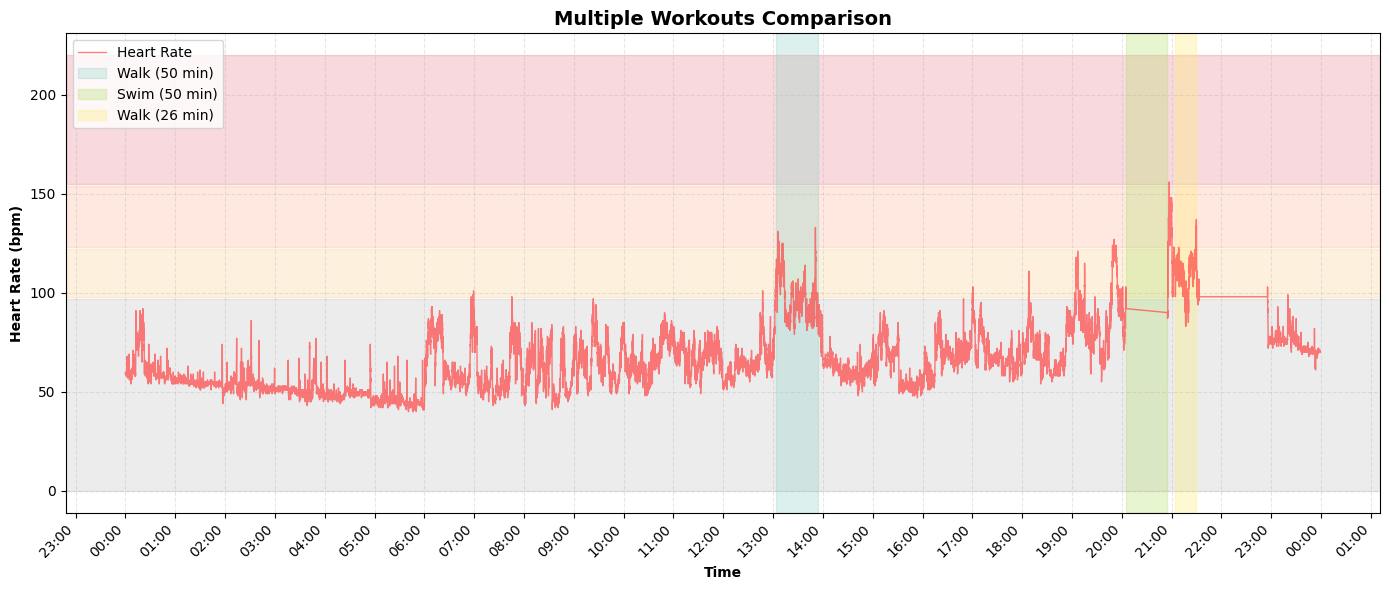

In [20]:
if len(df_activity_records) > 1:
    try:
        fig = plot_multiple_workouts_comparison(
            df_hr_intra,
            df_steps_intra,
            df_activity_records,
            hr_zones=hr_zones,
            timezone='Europe/London'
        )
        plt.show()
    except Exception as e:
        print(f"❌ Error plotting: {e}")
elif len(df_activity_records) <= 1:
    print("Only one activity found - comparison requires multiple workouts")
else:
    print("ℹ️  Multiple workouts comparison - switch to ANALYSIS_MODE = 'single' to use")

---

## 7. Multiple Activities Comparison 🔀

Side-by-side comparison when multiple activities exist on the same day:
- Compare heart rate patterns
- Compare intensity levels
- See how different activities affect your HR

In [21]:
# if len(df_activity_records) > 0:
#     # Select relevant columns
#     cols_to_show = [
#         'time', 'ActivityName', 'calories', 'distance', 'steps',
#         'speed', 'pace', 'averageHeartRate', 'duration',
#         'elevationGain'
#     ]
    
#     # Filter columns that exist
#     available_cols = [col for col in cols_to_show if col in df_activity_records.columns]
    
#     print("\n📊 Activity Details:")
#     print("="*100)
#     display(df_activity_records[available_cols])
# else:
#     print("ℹ️  Single-day activity table - switch to ANALYSIS_MODE = 'single' to use")

---

## 8. Activity Summary Table 📋

Quick overview of all activities with key metrics at a glance.

---

## 9. Running & Workout Analysis 🏃‍♂️

Comprehensive running/workout analysis including:
- **Pace & Speed**: Per kilometer pace, average speed, cadence
- **Kilometer Splits**: Estimated splits based on average pace
- **Efficiency Metrics**: Calories/km, steps/km, stride length
- **Heart Rate Analysis**: Zone distribution during the run
- **GPS Validation**: Compare API distance vs GPS distance

Searches for activities: Run, Jog, Structured Workout, Treadmill Run, Sport

In [22]:
# Analyse ALL activities
MILES_TO_KM = 1.609344

if len(df_activity_records) > 0:
    print(f"Found {len(df_activity_records)} activity session(s)\n")
    total_calories = df_activity_records['calories'].sum()
    print(f"🔥 Total calories burned: {total_calories:.0f} kcal\n")
    
    for idx, activity in df_activity_records.sort_values('time').iterrows():
        print(f"{'='*60}")
        print(f"{activity['ActivityName']} - {activity['time'].strftime('%Y-%m-%d %H:%M')}")
        print(f"{'='*60}\n")
        
        duration_sec = activity['duration'] / 1000
        duration_min = duration_sec / 60
        
        print(f"⏱️  Duration: {int(duration_min)}:{int((duration_min % 1) * 60):02d}")
        print(f"🔥 Calories: {activity['calories']:.0f} kcal")
        
        if pd.notna(activity.get('steps')) and activity['steps'] > 0:
            print(f"👣 Steps: {activity['steps']:.0f}")
        
        if pd.notna(activity.get('averageHeartRate')):
            print(f"❤️  Avg HR: {activity['averageHeartRate']:.0f} bpm")
        
        # Distance-based metrics (skip if no distance)
        has_distance = pd.notna(activity.get('distance')) and activity['distance'] > 0
        
        if has_distance:
            distance_miles = activity['distance']
            distance_km = distance_miles * MILES_TO_KM
            
            print(f"📏 Distance: {distance_km:.2f} km ({distance_miles:.2f} mi)")
            
            # Pace and speed
            pace_sec_per_km = duration_sec / distance_km
            speed_kmh = distance_km / (duration_sec / 3600)
            
            print(f"⚡ Pace: {int(pace_sec_per_km // 60)}:{int(pace_sec_per_km % 60):02d} /km")
            print(f"⚡ Speed: {speed_kmh:.2f} km/h")
            
            if pd.notna(activity.get('steps')) and activity['steps'] > 0:
                print(f"⚡ Cadence: {activity['steps'] / duration_min:.0f} spm")
            
            if pd.notna(activity.get('elevationGain')):
                print(f"⛰️  Elevation: +{activity['elevationGain']:.0f} m")
            
            # Efficiency
            print(f"\n📊 Efficiency:")
            print(f"   {activity['calories'] / distance_km:.1f} kcal/km")
            if pd.notna(activity.get('steps')) and activity['steps'] > 0:
                print(f"   {activity['steps'] / distance_km:.0f} steps/km")
                print(f"   {distance_km * 1000 / activity['steps']:.2f} m/step")
            
            # Km splits
            if distance_km >= 1.0:
                print(f"\n📊 Estimated Splits:")
                for km in range(1, int(distance_km) + 1):
                    elapsed = pace_sec_per_km * km
                    print(f"   km {km}: {int(pace_sec_per_km // 60)}:{int(pace_sec_per_km % 60):02d} | elapsed {int(elapsed // 60)}:{int(elapsed % 60):02d}")
                
                # Final partial km
                remaining = distance_km - int(distance_km)
                if remaining >= 0.1:
                    partial_time = remaining * pace_sec_per_km
                    print(f"   {remaining:.2f} km: {int(partial_time // 60)}:{int(partial_time % 60):02d} | elapsed {int(duration_sec // 60)}:{int(duration_sec % 60):02d}")
            
            # GPS check
            df_gps = dfs.get('GPS', pd.DataFrame())
            if not df_gps.empty:
                activity_id = f"{activity['time'].isoformat()}-{activity['ActivityName']}"
                activity_gps = df_gps[df_gps['ActivityID'] == activity_id]
                if not activity_gps.empty:
                    gps_km = activity_gps['distance'].max() / 1000
                    diff_m = abs(gps_km - distance_km) * 1000
                    print(f"\n🛰️  GPS: {len(activity_gps):,} points | {gps_km:.2f} km | Δ {diff_m:.0f}m")
                else:
                    print(f"\n📍 No GPS data")
            else:
                print(f"\n📍 No GPS data")
        
        # Heart rate analysis
        if not df_hr_intra.empty:
            try:
                from functions.performance_functions import extract_activity_time_window
                start, end, _ = extract_activity_time_window(activity, 'Europe/London')
                
                hr_data = df_hr_intra[(df_hr_intra['time'] >= start) & (df_hr_intra['time'] <= end)]
                
                if not hr_data.empty:
                    vals = hr_data['value']
                    print(f"\n❤️  HR Analysis ({len(hr_data):,} samples):")
                    print(f"   Avg: {vals.mean():.0f} | Min: {vals.min():.0f} | Max: {vals.max():.0f} bpm")
                    
                    for zone_name, zone_info in hr_zones.items():
                        lo, hi = zone_info['range']
                        in_zone = hr_data[(vals >= lo) & (vals < hi)]
                        pct = len(in_zone) / len(hr_data) * 100
                        if pct > 0:
                            print(f"   {zone_name}: {pct:.1f}% ({len(in_zone) / 60:.1f} min)")
            except Exception as e:
                print(f"\n⚠️  HR analysis failed: {e}")
        
        print()

else:
    print("No activities found for this date")

Found 3 activity session(s)

🔥 Total calories burned: 958 kcal

Walk - 2025-11-12 13:03

⏱️  Duration: 50:21
🔥 Calories: 367 kcal
👣 Steps: 5129
❤️  Avg HR: 98 bpm
📏 Distance: 4.04 km (2.51 mi)
⚡ Pace: 12:27 /km
⚡ Speed: 4.82 km/h
⚡ Cadence: 102 spm
⛰️  Elevation: +60 m

📊 Efficiency:
   90.8 kcal/km
   1269 steps/km
   0.79 m/step

📊 Estimated Splits:
   km 1: 12:27 | elapsed 12:27
   km 2: 12:27 | elapsed 24:54
   km 3: 12:27 | elapsed 37:22
   km 4: 12:27 | elapsed 49:49

📍 No GPS data

❤️  HR Analysis (1,522 samples):
   Avg: 98 | Min: 79 | Max: 133 bpm
   Out of Range: 53.7% (13.6 min)
   Fat Burn: 39.7% (10.1 min)
   Cardio: 2.8% (0.7 min)

Swim - 2025-11-12 20:05

⏱️  Duration: 49:50
🔥 Calories: 400 kcal
❤️  Avg HR: 92 bpm
📏 Distance: 2.23 km (1.38 mi)
⚡ Pace: 22:23 /km
⚡ Speed: 2.68 km/h
⛰️  Elevation: +0 m

📊 Efficiency:
   179.8 kcal/km

📊 Estimated Splits:
   km 1: 22:23 | elapsed 22:23
   km 2: 22:23 | elapsed 44:47
   0.23 km: 5:02 | elapsed 49:50

📍 No GPS data

❤️  HR Ana

---

## 10. GPS Track Visualization 🗺️

For GPS-tracked runs, visualize:
- **Heart rate & pace** progression over distance
- **Elevation profile** showing climbs and descents
- **Kilometer splits** with color coding (green = faster, red = slower)

*Note: Treadmill runs typically don't have reliable GPS data*

In [23]:
# Visualize pace variation and heart rate for GPS-tracked activities
df_gps = dfs.get('GPS', pd.DataFrame())

# Look for any activity with distance data (runs, walks, etc.)
gps_activities = df_activity_records[
    df_activity_records['distance'].notna() & 
    (df_activity_records['distance'] > 0)
].copy()

if len(gps_activities) > 0 and not df_gps.empty:
    # Check what columns the GPS data has
    if 'ActivityID' not in df_gps.columns:
        print("⚠️  GPS data doesn't have ActivityID column")
        print(f"   Available columns: {list(df_gps.columns)}")
        print("\n   This cell requires GPS data with ActivityID to match activities.")
        print("   Skipping GPS visualization.\n")
    else:
        activities_with_gps = 0
        
        for idx, activity in gps_activities.iterrows():
            # Convert datetime to ISO format string to match GPS ActivityID format
            time_str = activity['time'].isoformat()
            activity_id = f"{time_str}-{activity['ActivityName']}"
            activity_gps = df_gps[df_gps['ActivityID'] == activity_id].copy()
            
            if not activity_gps.empty and 'heart_rate' in activity_gps:
                activities_with_gps += 1
                
                print(f"{'='*80}")
                print(f"GPS VISUALIZATION - {activity['ActivityName']} - {activity['time'].strftime('%Y-%m-%d %H:%M')}")
                print(f"{'='*80}\n")
                
                activity_gps = activity_gps.sort_values('distance')
                activity_gps['time'] = pd.to_datetime(activity_gps['time'])
                
                # Calculate rolling pace (pace for each 100m segment)
                activity_gps['distance_km'] = activity_gps['distance'] / 1000
                
                # Create figure with 3 subplots
                fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))
                
                # ================================================================
                # Plot 1: Heart Rate and Pace over Distance
                # ================================================================
                
                ax1_twin = ax1.twinx()
                
                # Plot heart rate
                ax1.plot(activity_gps['distance_km'], activity_gps['heart_rate'], 
                        color='#ff4444', linewidth=2, label='Heart Rate', alpha=0.8)
                ax1.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
                ax1.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold', color='#ff4444')
                ax1.tick_params(axis='y', labelcolor='#ff4444')
                ax1.grid(True, alpha=0.3)
                
                # Calculate rolling pace (using 200m windows)
                window_size = 40  # ~200m at 5m per point
                if len(activity_gps) > window_size:
                    activity_gps['time_diff'] = activity_gps['time'].diff().dt.total_seconds()
                    activity_gps['dist_diff'] = activity_gps['distance'].diff()
                    activity_gps['rolling_pace'] = (activity_gps['time_diff'] / (activity_gps['dist_diff'] / 1000))
                    
                    # Remove outliers (pace < 2 min/km or > 30 min/km for walking)
                    activity_gps.loc[(activity_gps['rolling_pace'] < 120) | (activity_gps['rolling_pace'] > 1800), 'rolling_pace'] = np.nan
                    
                    # Smooth the pace data
                    activity_gps['rolling_pace_smooth'] = activity_gps['rolling_pace'].rolling(window=window_size, center=True).mean()
                    
                    # Convert to min/km for display
                    activity_gps['pace_min_km'] = activity_gps['rolling_pace_smooth'] / 60
                    
                    ax1_twin.plot(activity_gps['distance_km'], activity_gps['pace_min_km'],
                                color='#4444ff', linewidth=2, label='Pace', alpha=0.6)
                    ax1_twin.set_ylabel('Pace (min/km)', fontsize=12, fontweight='bold', color='#4444ff')
                    ax1_twin.tick_params(axis='y', labelcolor='#4444ff')
                    ax1_twin.invert_yaxis()  # Faster pace at top
                
                ax1.set_title(f'{activity["ActivityName"]} - Heart Rate & Pace Profile', 
                             fontsize=14, fontweight='bold')
                
                # ================================================================
                # Plot 2: Elevation Profile
                # ================================================================
                
                if 'altitude' in activity_gps:
                    ax2.fill_between(activity_gps['distance_km'], activity_gps['altitude'], 
                                    alpha=0.3, color='#8B4513')
                    ax2.plot(activity_gps['distance_km'], activity_gps['altitude'], 
                            color='#8B4513', linewidth=2, label='Elevation')
                    ax2.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
                    ax2.set_ylabel('Elevation (m)', fontsize=12, fontweight='bold')
                    ax2.set_title('Elevation Profile', fontsize=14, fontweight='bold')
                    ax2.grid(True, alpha=0.3)
                    
                    # Add stats
                    elev_gain = activity.get('elevationGain', 0)
                    elev_range = activity_gps['altitude'].max() - activity_gps['altitude'].min()
                    ax2.text(0.02, 0.98, f'Gain: {elev_gain:.0f}m | Range: {elev_range:.0f}m',
                            transform=ax2.transAxes, va='top', fontsize=10,
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                else:
                    ax2.text(0.5, 0.5, 'No elevation data available', 
                            ha='center', va='center', fontsize=14, transform=ax2.transAxes)
                    ax2.set_title('Elevation Profile', fontsize=14, fontweight='bold')
                
                # ================================================================
                # Plot 3: Kilometer Splits Bar Chart
                # ================================================================
                
                # Convert distance from miles to km for this activity
                MILES_TO_KM = 1.609344
                distance_km = activity['distance'] * MILES_TO_KM
                splits_data = []
                
                for km in range(1, int(distance_km) + 1):
                    km_distance_m = km * 1000
                    closest_idx = (activity_gps['distance'] - km_distance_m).abs().idxmin()
                    km_point = activity_gps.loc[closest_idx]
                    
                    if km == 1:
                        prev_point = activity_gps.iloc[0]
                    else:
                        prev_km_m = (km - 1) * 1000
                        prev_idx = (activity_gps['distance'] - prev_km_m).abs().idxmin()
                        prev_point = activity_gps.loc[prev_idx]
                    
                    split_seconds = (km_point['time'] - prev_point['time']).total_seconds()
                    km_actual_distance = (km_point['distance'] - prev_point['distance']) / 1000
                    
                    if km_actual_distance > 0:
                        split_pace = split_seconds / km_actual_distance
                        splits_data.append({'km': km, 'pace': split_pace})
                
                if splits_data:
                    splits_df = pd.DataFrame(splits_data)
                    
                    # Color bars by pace (faster = green, slower = red)
                    avg_pace = splits_df['pace'].mean()
                    colors = ['#00aa00' if p <= avg_pace else '#aa0000' for p in splits_df['pace']]
                    
                    bars = ax3.bar(splits_df['km'], splits_df['pace'] / 60, color=colors, 
                                  edgecolor='black', linewidth=1.5, alpha=0.7)
                    
                    # Add pace labels on bars
                    for bar, pace in zip(bars, splits_df['pace']):
                        height = bar.get_height()
                        pace_min = int(pace // 60)
                        pace_sec = int(pace % 60)
                        ax3.text(bar.get_x() + bar.get_width()/2., height,
                               f'{pace_min}:{pace_sec:02d}',
                               ha='center', va='bottom', fontsize=9, fontweight='bold')
                    
                    # Add average pace line
                    ax3.axhline(avg_pace / 60, color='blue', linestyle='--', linewidth=2, 
                               label=f'Avg: {int(avg_pace//60)}:{int(avg_pace%60):02d}', alpha=0.7)
                    
                    ax3.set_xlabel('Kilometer', fontsize=12, fontweight='bold')
                    ax3.set_ylabel('Pace (min/km)', fontsize=12, fontweight='bold')
                    ax3.set_title('Kilometer Splits (Green = faster than avg, Red = slower)', 
                                 fontsize=14, fontweight='bold')
                    ax3.set_xticks(splits_df['km'])
                    ax3.legend()
                    ax3.grid(True, alpha=0.3, axis='y')
                else:
                    ax3.text(0.5, 0.5, f'Activity distance too short for km splits ({distance_km:.2f} km)', 
                            ha='center', va='center', fontsize=12, transform=ax3.transAxes)
                    ax3.set_title('Kilometer Splits', fontsize=14, fontweight='bold')
                
                plt.tight_layout()
                plt.show()
                
                print(f"✅ GPS data visualized for {activity['ActivityName']}")
                print("="*80 + "\n")
        
        if activities_with_gps == 0:
            print("⚠️  No GPS data found for any activities")
            print(f"   Checked {len(gps_activities)} activities with distance data")
            print(f"   GPS records in database: {len(df_gps)}")
else:
    if len(gps_activities) == 0:
        print("No activities with distance data found")
    elif df_gps.empty:
        print("No GPS data available in dataset")

No GPS data available in dataset


In [24]:
# GPS Route Map Visualization
df_gps = dfs.get('GPS', pd.DataFrame())

if not df_gps.empty:
    print(f"✅ Found {len(df_gps):,} GPS trackpoints total")
    print(f"📋 GPS columns: {list(df_gps.columns)}\n")
    
    # Group by activity to visualize each route separately
    if 'ActivityID' in df_gps.columns:
        activities = df_gps['ActivityID'].unique()
        print(f"🗺️  GPS data available for {len(activities)} activity/activities")
        print(f"   Activity IDs: {list(activities)}\n")
        
        for activity_id in activities:
            activity_gps = df_gps[df_gps['ActivityID'] == activity_id].copy()
            
            # Extract activity name from ActivityID (format: "timestamp-ActivityName")
            activity_name = activity_id.split('-')[-1] if '-' in activity_id else 'Unknown'
            
            print(f"{'='*80}")
            print(f"GPS ROUTE MAP - {activity_name} ({len(activity_gps):,} points)")
            print(f"{'='*80}\n")
            
            # Check required columns (Fitbit uses 'lat' and 'lon', not 'latitude' and 'longitude')
            if 'lat' not in activity_gps.columns or 'lon' not in activity_gps.columns:
                print(f"⚠️  Missing lat/lon data")
                print(f"   Available columns: {list(activity_gps.columns)}\n")
                continue
            
            # Check for valid coordinates
            valid_coords = activity_gps['lat'].notna() & activity_gps['lon'].notna()
            activity_gps = activity_gps[valid_coords]
            
            if len(activity_gps) == 0:
                print("⚠️  No valid GPS coordinates found\n")
                continue
            
            print(f"   Valid coordinates: {len(activity_gps):,}")
            print(f"   Lat range: {activity_gps['lat'].min():.6f} to {activity_gps['lat'].max():.6f}")
            print(f"   Lon range: {activity_gps['lon'].min():.6f} to {activity_gps['lon'].max():.6f}\n")
            
            # Sort by distance to ensure correct route order
            if 'distance' in activity_gps.columns:
                activity_gps = activity_gps.sort_values('distance')
            
            # Create figure with 2 subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
            
            # ================================================================
            # Plot 1: Route Map colored by Heart Rate
            # ================================================================
            
            if 'heart_rate' in activity_gps.columns and activity_gps['heart_rate'].notna().any():
                # Create scatter plot with heart rate color coding
                scatter = ax1.scatter(activity_gps['lon'], activity_gps['lat'],
                                     c=activity_gps['heart_rate'], cmap='RdYlGn_r',
                                     s=20, alpha=0.6, edgecolors='none')
                
                # Add colorbar
                cbar = plt.colorbar(scatter, ax=ax1)
                cbar.set_label('Heart Rate (bpm)', fontsize=11, fontweight='bold')
                
                title_suffix = 'colored by Heart Rate'
            else:
                # Simple route without HR coloring
                ax1.plot(activity_gps['lon'], activity_gps['lat'],
                        'b-', linewidth=2, alpha=0.6)
                ax1.scatter(activity_gps['lon'], activity_gps['lat'],
                           c='blue', s=20, alpha=0.4)
                title_suffix = ''
            
            # Mark start and end points
            start = activity_gps.iloc[0]
            end = activity_gps.iloc[-1]
            
            ax1.scatter(start['lon'], start['lat'], 
                       c='green', s=200, marker='o', edgecolors='black', 
                       linewidth=2, label='Start', zorder=10)
            ax1.scatter(end['lon'], end['lat'], 
                       c='red', s=200, marker='X', edgecolors='black', 
                       linewidth=2, label='End', zorder=10)
            
            ax1.set_xlabel('Longitude', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Latitude', fontsize=12, fontweight='bold')
            ax1.set_title(f'GPS Route Map {title_suffix}', fontsize=14, fontweight='bold')
            ax1.grid(True, alpha=0.3)
            ax1.legend(fontsize=11)
            ax1.set_aspect('equal', adjustable='box')
            
            # ================================================================
            # Plot 2: Route Map colored by Pace/Speed
            # ================================================================
            
            if 'distance' in activity_gps.columns:
                # Calculate instantaneous speed
                activity_gps['time_dt'] = pd.to_datetime(activity_gps['time'])
                activity_gps['time_diff'] = activity_gps['time_dt'].diff().dt.total_seconds()
                activity_gps['dist_diff'] = activity_gps['distance'].diff()
                
                # Speed in km/h
                activity_gps['speed_kmh'] = (activity_gps['dist_diff'] / activity_gps['time_diff']) * 3.6
                
                # Remove outliers (speed > 30 km/h unlikely for walking/running)
                activity_gps.loc[activity_gps['speed_kmh'] > 30, 'speed_kmh'] = np.nan
                activity_gps.loc[activity_gps['speed_kmh'] < 0, 'speed_kmh'] = np.nan
                
                # Smooth the speed data
                activity_gps['speed_smooth'] = activity_gps['speed_kmh'].rolling(window=10, center=True).mean()
                
                # Create scatter plot with speed color coding
                scatter2 = ax2.scatter(activity_gps['lon'], activity_gps['lat'],
                                      c=activity_gps['speed_smooth'], cmap='viridis',
                                      s=20, alpha=0.6, edgecolors='none', 
                                      vmin=0, vmax=activity_gps['speed_smooth'].quantile(0.95))
                
                # Add colorbar
                cbar2 = plt.colorbar(scatter2, ax=ax2)
                cbar2.set_label('Speed (km/h)', fontsize=11, fontweight='bold')
                
                title2 = 'GPS Route Map colored by Speed'
            else:
                # Fallback: simple route plot
                ax2.plot(activity_gps['lon'], activity_gps['lat'],
                        'purple', linewidth=2, alpha=0.6)
                ax2.scatter(activity_gps['lon'], activity_gps['lat'],
                           c='purple', s=20, alpha=0.4)
                title2 = 'GPS Route Map'
            
            # Mark start and end points
            ax2.scatter(start['lon'], start['lat'], 
                       c='green', s=200, marker='o', edgecolors='black', 
                       linewidth=2, label='Start', zorder=10)
            ax2.scatter(end['lon'], end['lat'], 
                       c='red', s=200, marker='X', edgecolors='black', 
                       linewidth=2, label='End', zorder=10)
            
            ax2.set_xlabel('Longitude', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Latitude', fontsize=12, fontweight='bold')
            ax2.set_title(title2, fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            ax2.legend(fontsize=11)
            ax2.set_aspect('equal', adjustable='box')
            
            plt.tight_layout()
            plt.show()
            
            # Print route stats
            if 'distance' in activity_gps.columns:
                total_distance_m = activity_gps['distance'].max()
                total_distance_km = total_distance_m / 1000
                print(f"\n📍 Route Statistics:")
                print(f"   Total trackpoints: {len(activity_gps):,}")
                print(f"   Distance covered: {total_distance_km:.2f} km")
                
                if 'altitude' in activity_gps.columns:
                    elev_range = activity_gps['altitude'].max() - activity_gps['altitude'].min()
                    print(f"   Elevation range: {elev_range:.1f} m")
                
                # Calculate bounding box
                lat_range = activity_gps['lat'].max() - activity_gps['lat'].min()
                lon_range = activity_gps['lon'].max() - activity_gps['lon'].min()
                print(f"   Lat range: {lat_range:.5f}° ({lat_range * 111:.2f} km)")
                print(f"   Lon range: {lon_range:.5f}° ({lon_range * 111:.2f} km)")
            
            print("\n")
    else:
        print("⚠️  GPS data doesn't have ActivityID column")
        print(f"   Available columns: {list(df_gps.columns)}")
        print("\n   Showing first few rows of GPS data:")
        print(df_gps.head())
else:
    print("❌ No GPS data available in dataset")

❌ No GPS data available in dataset


## 10. Swim-Specific Analysis

Detailed analysis for swimming sessions including pace per 100m, GPS data, and heart rate during swim

**⚠️ Known Issue:** Fitbit API returns swim distances in **miles** (not km like other activities). This notebook converts them correctly, but `fitbit2s3.py` should be updated to handle this at the data collection stage for future consistency.

In [25]:
# Configuration
POOL_LENGTH = 25  # meters
MILES_TO_KM = 1.609344  # Conversion factor

# Find all swim activities
swim_activities = df_activity_records[df_activity_records['ActivityName'] == 'Swim'].copy()

if len(swim_activities) > 0:
    print(f"Found {len(swim_activities)} swim session(s)\n")
    
    for idx, swim in swim_activities.iterrows():
        print(f"{'='*80}")
        print(f"SWIM SESSION ANALYSIS - {swim['time']}")
        print(f"{'='*80}\n")
        
        # FIX: Fitbit API returns swim distances in MILES, not kilometers!
        # Convert to meters correctly
        distance_from_api = swim['distance']  # This is in MILES for swimming
        distance_m = distance_from_api * MILES_TO_KM * 1000  # Convert miles -> km -> meters
        distance_km = distance_m / 1000
        
        print(f"⚠️ Note: Fitbit returns swim distance in miles ({distance_from_api:.3f} mi)")
        print(f"📏 Distance: {distance_m:.0f} meters ({distance_km:.2f} km)")
        
        # Duration
        duration_min = swim['duration'] / 1000 / 60
        duration_sec = swim['duration'] / 1000
        
        print(f"⏱️ Duration: {duration_min:.1f} minutes ({duration_sec:.0f} seconds)")
        print(f"🔥 Calories: {swim['calories']:.0f} kcal")
        
        # Recalculate speed with correct distance
        speed_kmh = (distance_km / duration_sec) * 3600
        print(f"⚡ Speed: {speed_kmh:.2f} km/h\n")
        
        # Calculate pace per 100m with CORRECT distance
        pace_sec_per_100m = duration_sec / (distance_m / 100)
        pace_min = int(pace_sec_per_100m // 60)
        pace_sec = int(pace_sec_per_100m % 60)
        
        print(f"🏊 Pace per 100m: {pace_min}:{pace_sec:02d} min/100m")
        
        # Laps in 25m pool
        laps = distance_m / POOL_LENGTH
        complete_laps = int(laps)
        
        print(f"\n🔄 Laps ({POOL_LENGTH}m pool): {laps:.1f} laps ({complete_laps} complete laps)")
        
        # Length breakdown
        complete_lengths = int(distance_m / POOL_LENGTH)
        remaining_meters = distance_m % POOL_LENGTH
        print(f"   = {complete_lengths} lengths", end='')
        if remaining_meters >= 1:
            print(f" + {remaining_meters:.0f}m")
        else:
            print()
        
        # Average time per lap
        if complete_laps > 0:
            sec_per_lap = duration_sec / laps
            lap_min = int(sec_per_lap // 60)
            lap_sec = int(sec_per_lap % 60)
            print(f"   Average time per lap: {lap_min}:{lap_sec:02d}")
        
        print(f"\n📊 Additional Metrics:")
        print(f"   Calories per 100m: {(swim['calories'] / (distance_m / 100)):.1f} kcal")
        print(f"   Meters per minute: {distance_m / duration_min:.1f} m/min")
        
        print(f"\n")
else:
    print("No swim activities found for this date")

Found 1 swim session(s)

SWIM SESSION ANALYSIS - 2025-11-12 20:05:05+00:00

⚠️ Note: Fitbit returns swim distance in miles (1.383 mi)
📏 Distance: 2225 meters (2.23 km)
⏱️ Duration: 49.8 minutes (2990 seconds)
🔥 Calories: 400 kcal
⚡ Speed: 2.68 km/h

🏊 Pace per 100m: 2:14 min/100m

🔄 Laps (25m pool): 89.0 laps (89 complete laps)
   = 89 lengths
   Average time per lap: 0:33

📊 Additional Metrics:
   Calories per 100m: 18.0 kcal
   Meters per minute: 44.6 m/min




---

## 11. Swimming Analysis 🏊‍♂️

Specialized metrics for pool swimming:
- **Pace per 100m**: Swimming-specific pace calculation
- **Lap counting**: Total laps and lengths in pool
- **Pool metrics**: Based on 25m pool length (configurable)
- **Efficiency**: Calories per 100m, meters per minute

**⚠️ Note:** Fitbit returns swim distances in miles - this is corrected automatically

In [26]:
# # Debug: Check what activity types are available in the data
# print("="*80)
# print("ACTIVITY TYPES IN DATA")
# print("="*80)

# if not df_activity_records.empty:
#     activity_types = df_activity_records['ActivityName'].value_counts()
    
#     print(f"\nFound {len(activity_types)} different activity types:")
#     print(f"\n{'Activity Type':30s} | Count")
#     print("-" * 45)
#     for activity_type, count in activity_types.items():
#         print(f"{activity_type:30s} | {count:5d}")
    
#     # Check for swimming activities
#     swim_activities = df_activity_records[
#         df_activity_records['ActivityName'].str.contains('Swim', case=False, na=False)
#     ]
    
#     if not swim_activities.empty:
#         print(f"\n✅ Found {len(swim_activities)} swim activity/activities!")
#         for idx, swim in swim_activities.iterrows():
#             print(f"   - {swim['ActivityName']} on {swim['time']}")
#     else:
#         print(f"\n⚠️  No swim activities found in the current date ({TARGET_DATE})")
#         print(f"   Try selecting a different date that includes swimming")
# else:
#     print("\n⚠️  No activity records found")
#     print(f"   Check that target_date ({target_date}) has activity data")

In [27]:
# Check for GPS data
df_gps = dfs.get('GPS', pd.DataFrame())

if not df_gps.empty:
    print(f"✅ Found {len(df_gps)} GPS trackpoints\n")
    print(df_gps.head(10))
else:
    print("⚠️  No GPS data found (expected for pool swimming)\n")

# Check if there's heart rate data during swim sessions
if len(swim_activities) > 0 and not df_hr_intra.empty:
    print(f"\n{'='*80}")
    print("HEART RATE DURING SWIM")
    print(f"{'='*80}\n")
    
    for idx, swim in swim_activities.iterrows():
        # Extract activity time window
        from functions.performance_functions import extract_activity_time_window
        swim_start, swim_end, duration = extract_activity_time_window(swim, 'Europe/London')
        
        # Filter HR data to swim window
        hr_during_swim = df_hr_intra[
            (df_hr_intra['time'] >= swim_start) & 
            (df_hr_intra['time'] <= swim_end)
        ].copy()
        
        if not hr_during_swim.empty:
            print(f"Swim at {swim['time']}:")
            print(f"  ✅ Found {len(hr_during_swim)} heart rate measurements during swim")
            print(f"  📊 HR Statistics:")
            print(f"     - Average: {hr_during_swim['value'].mean():.1f} bpm")
            print(f"     - Min: {hr_during_swim['value'].min():.0f} bpm")
            print(f"     - Max: {hr_during_swim['value'].max():.0f} bpm")
            print(f"     - Median: {hr_during_swim['value'].median():.1f} bpm\n")
            
            # Show HR distribution
            print(f"  HR Zone Distribution:")
            for zone_name, zone_info in hr_zones.items():
                hr_in_zone = hr_during_swim[
                    (hr_during_swim['value'] >= zone_info['range'][0]) &
                    (hr_during_swim['value'] < zone_info['range'][1])
                ]
                pct = (len(hr_in_zone) / len(hr_during_swim)) * 100
                print(f"     - {zone_name:15s}: {pct:5.1f}% ({len(hr_in_zone):4d} measurements)")
        else:
            print(f"  ⚠️  No heart rate data found during swim (watch may not track HR in water)\n")

⚠️  No GPS data found (expected for pool swimming)


HEART RATE DURING SWIM

Swim at 2025-11-12 20:05:05+00:00:
  ✅ Found 1 heart rate measurements during swim
  📊 HR Statistics:
     - Average: 92.0 bpm
     - Min: 92 bpm
     - Max: 92 bpm
     - Median: 92.0 bpm

  HR Zone Distribution:
     - Out of Range   : 100.0% (   1 measurements)
     - Fat Burn       :   0.0% (   0 measurements)
     - Cardio         :   0.0% (   0 measurements)
     - Peak           :   0.0% (   0 measurements)


---

## 12. Swimming Heart Rate Analysis 💓

Analyze heart rate during swimming sessions:
- Check if watch tracked HR in water
- Zone distribution during swim
- Average, min, max HR during swim

*Note: Some watches may not track HR underwater*

---

## 13. Daily Heart Rate Timeline 🕐

Full day visualization showing:
- Heart rate zones as colored bands
- Your actual HR throughout the day
- All activities highlighted with colored regions
- See how activities spike your HR and recovery patterns

---

## 16. Activity vs Heart Rate Summary 📊

Compare your movement levels with cardiovascular activity:
- **Activity levels** (Fitbit's motion-based classification)
- **Heart rate zones** (actual cardiovascular effort)
- **WHO Guidelines**: 150 minutes moderate activity per week (~21 min/day)
- See if your active time correlates with elevated heart rate

HEART RATE TIMELINE WITH ACTIVITIES



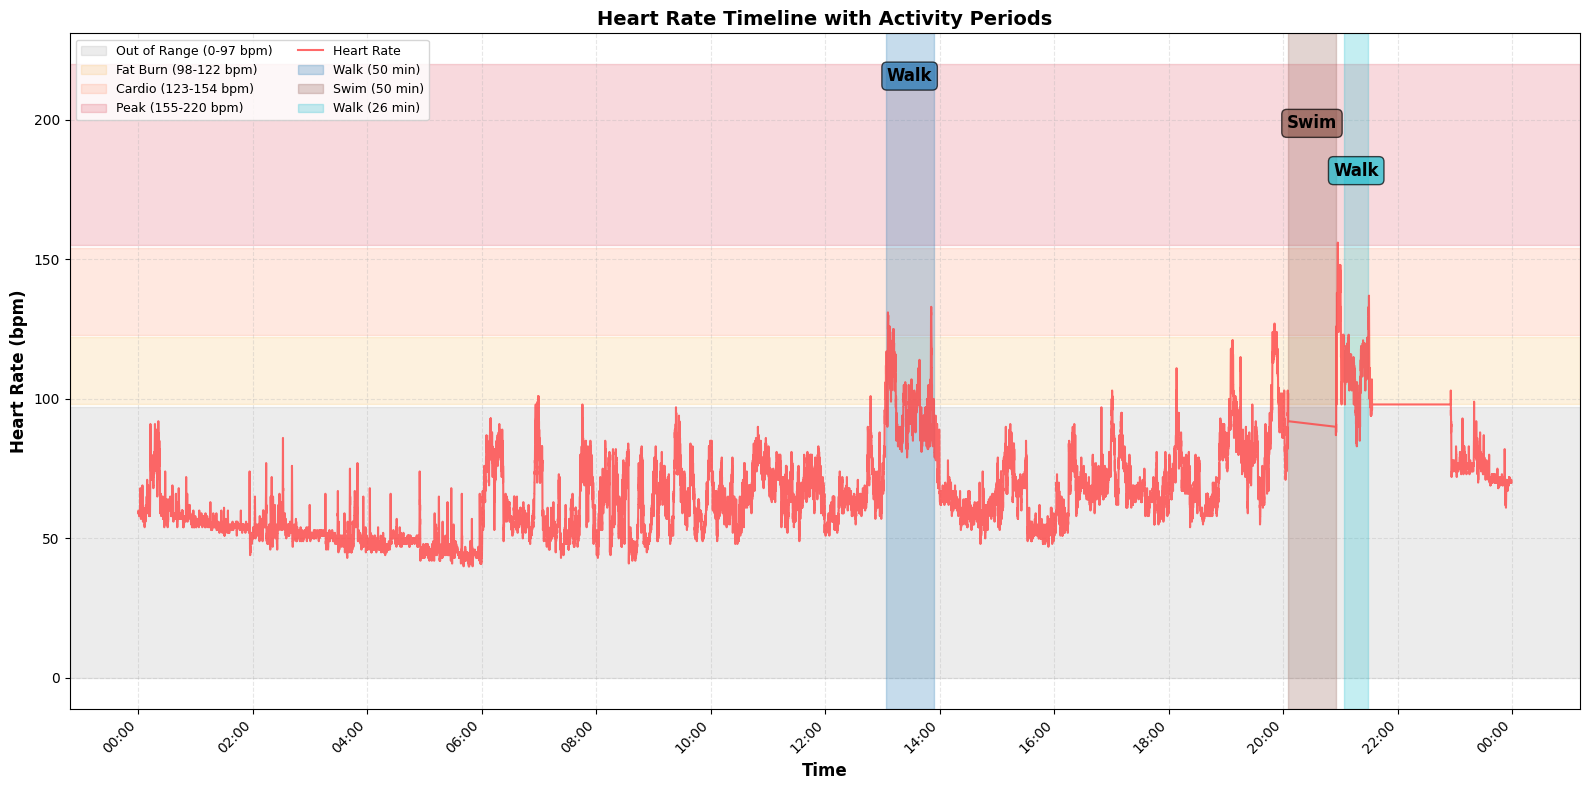


Timeline shows:
  - Colored bands: Heart rate zones
  - Red line: Your actual heart rate throughout the day
  - Highlighted regions: Activity periods
  - You can see how activities affect your HR and which zones you reached


In [28]:
# Timeline view: HR zones with activities highlighted
if not df_hr_intra.empty and len(df_activity_records) > 0:
    print("="*80)
    print("HEART RATE TIMELINE WITH ACTIVITIES")
    print("="*80 + "\n")
    
    from functions.performance_functions import convert_timezone_safe, extract_activity_time_window
    
    # Convert HR data to local timezone for plotting
    df_hr_plot = convert_timezone_safe(df_hr_intra.copy(), target_tz='Europe/London')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot HR zones as background bands
    for zone_name, zone_info in hr_zones.items():
        ax.axhspan(zone_info['range'][0], zone_info['range'][1], 
                  alpha=0.15, color=zone_info['color'], 
                  label=f"{zone_name} ({zone_info['range'][0]}-{zone_info['range'][1]} bpm)")
    
    # Plot heart rate line
    ax.plot(df_hr_plot['time'], df_hr_plot['value'], 
           color='#ff4444', linewidth=1.5, alpha=0.8, label='Heart Rate', zorder=5)
    
    # Highlight activity periods
    activity_colors = plt.cm.tab10(np.linspace(0, 1, len(df_activity_records)))

    # Stagger labels at different heights
    label_heights = [0.95, 0.88, 0.81, 0.74]  # Cycle through these

    for idx, (activity_idx, activity) in enumerate(df_activity_records.iterrows()):
        activity_start, activity_end, duration = extract_activity_time_window(activity, 'Europe/London')
        
        # Add vertical span for activity
        ax.axvspan(activity_start, activity_end, 
                  alpha=0.25, color=activity_colors[idx], 
                  label=f"{activity['ActivityName']} ({duration:.0f} min)", zorder=2)
        
        # Add text label at the top
        mid_time = activity_start + (activity_end - activity_start) / 2
        height_pct = label_heights[idx % len(label_heights)]
            
        # Use transform to place in axes coordinates for y, data coordinates for x
        ax.text(mid_time, height_pct, 
               activity['ActivityName'], 
               ha='center', va='top', fontsize=12, fontweight='bold',
               transform=ax.get_xaxis_transform(),  # x=data coords, y=axes coords (0-1)
               bbox=dict(boxstyle='round,pad=0.3', facecolor=activity_colors[idx], alpha=0.7))
    
    # Customize plot
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold')
    ax.set_title('Heart Rate Timeline with Activity Periods', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Legend
    ax.legend(loc='upper left', fontsize=9, ncol=2)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTimeline shows:")
    print("  - Colored bands: Heart rate zones")
    print("  - Red line: Your actual heart rate throughout the day")
    print("  - Highlighted regions: Activity periods")
    print("  - You can see how activities affect your HR and which zones you reached")
    
else:
    print("Need both heart rate data and activity records for timeline view")

---

## 14. Activity Level Distribution 🎯

Fitbit categorizes your day into four activity levels:
- **Sedentary**: Sitting, lying down, minimal movement
- **Lightly Active**: Casual walking, light household tasks
- **Fairly Active**: Brisk walking, active chores
- **Very Active**: Running, intense exercise, sports

Shows how you spend your 24 hours.

ACTIVITY LEVEL DISTRIBUTION



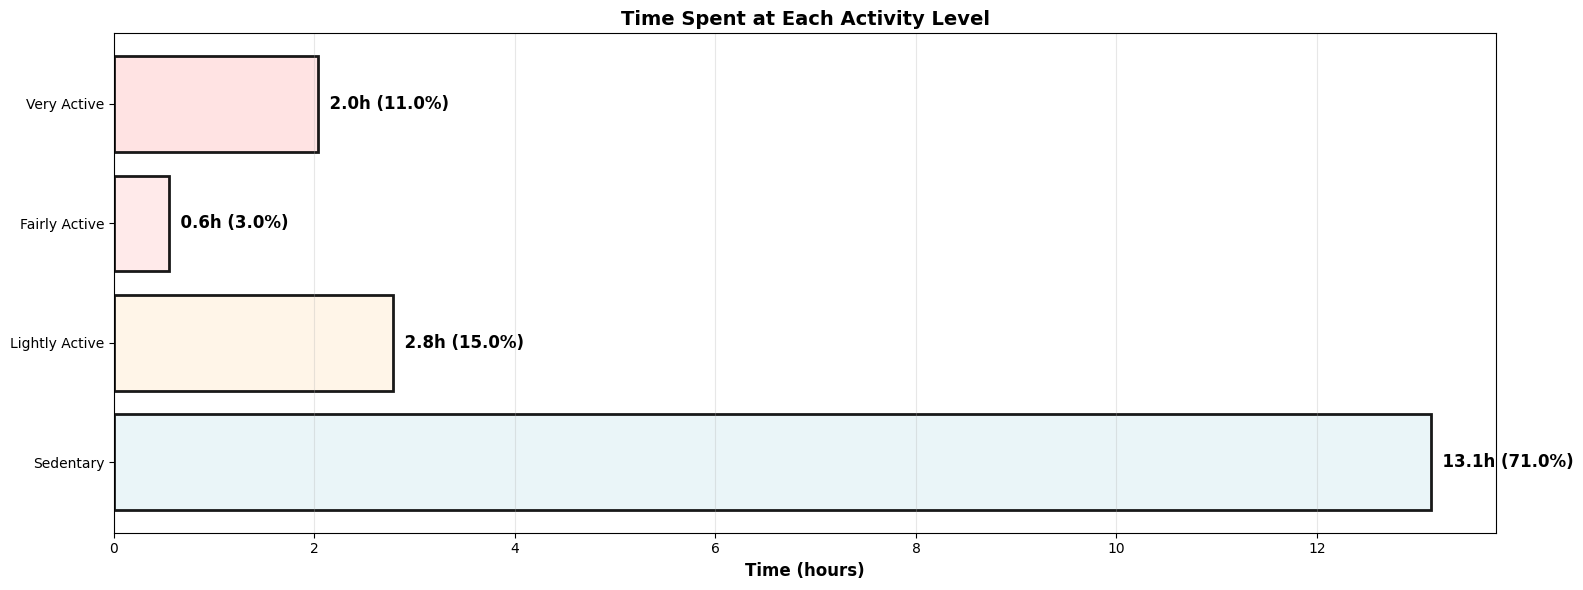

In [29]:
# Extract activity level data
activity_levels = {
    'Sedentary': dfs.get('Activity-minutesSedentary', pd.DataFrame()),
    'Lightly Active': dfs.get('Activity-minutesLightlyActive', pd.DataFrame()),
    'Fairly Active': dfs.get('Activity-minutesFairlyActive', pd.DataFrame()),
    'Very Active': dfs.get('Activity-minutesVeryActive', pd.DataFrame())
}
# Check if we have activity level data
has_data = any(not df.empty for df in activity_levels.values())
if has_data:
    print("="*80)
    print("ACTIVITY LEVEL DISTRIBUTION")
    print("="*80 + "\n")
    
    # Collect data
    level_data = []
    total_minutes = 0
    
    # Define colors for activity levels
    level_colors = {
        'Sedentary': '#E8F4F8',
        'Lightly Active': '#FFF4E6',
        'Fairly Active': '#FFE8E8',
        'Very Active': '#FFE0E0'
    }
    
    for level_name, df in activity_levels.items():
        if not df.empty:
            minutes = df.iloc[0]['value']
            hours = minutes / 60
            total_minutes += minutes
            
            level_data.append({
                'level': level_name,
                'minutes': minutes,
                'hours': hours,
                'color': level_colors[level_name]
            })
    
    # Calculate percentages
    for item in level_data:
        item['percentage'] = (item['minutes'] / total_minutes) * 100 if total_minutes > 0 else 0
    
    # Create visualizations
    fig, ax = plt.subplots(figsize=(16, 6))
    
    levels = [item['level'] for item in level_data]
    hours = [item['hours'] for item in level_data]
    colors = [item['color'] for item in level_data]
    
    bars = ax.barh(levels, hours, color=colors, edgecolor='black', linewidth=2, alpha=0.9)
    
    # Add value labels
    for bar, item in zip(bars, level_data):
        width = bar.get_width()
        label = f"{item['hours']:.1f}h ({item['percentage']:.1f}%)"
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'  {label}', 
                va='center', fontsize=12, fontweight='bold')
    
    ax.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
    ax.set_title('Time Spent at Each Activity Level', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
else:
    print("No activity level data available")

In [30]:
if not df_hr_intra.empty:
    print(f"Analyzing {len(df_hr_intra):,} heart rate measurements\n")
    
    # Calculate time in each zone
    zone_data = []
    zone_colors = []
    
    for zone_name, zone_info in hr_zones.items():
        hr_in_zone = df_hr_intra[
            (df_hr_intra['value'] >= zone_info['range'][0]) &
            (df_hr_intra['value'] < zone_info['range'][1])
        ]
        
        # Each measurement is ~1 second apart for HR data
        minutes_in_zone = len(hr_in_zone) / 60
        hours_in_zone = minutes_in_zone / 60
        percentage = (len(hr_in_zone) / len(df_hr_intra)) * 100
        
        zone_data.append({
            'zone': zone_name,
            'count': len(hr_in_zone),
            'minutes': minutes_in_zone,
            'hours': hours_in_zone,
            'percentage': percentage,
            'color': zone_info['color'],
            'range': f"{zone_info['range'][0]}-{zone_info['range'][1]} bpm"
        })
        zone_colors.append(zone_info['color'])
else:
    print("No heart rate data available")

Analyzing 36,955 heart rate measurements



---

## 15. Heart Rate Zone Distribution ❤️‍🔥

Calculate time spent in each heart rate zone throughout the day:
- Each HR measurement is ~1 second apart
- Total time and percentage in each zone
- Helps understand daily cardiovascular load

In [31]:
# Combined view: Activity Levels vs HR Zones
print("\n" + "="*80)
print("ACTIVITY LEVELS vs. HEART RATE ZONES COMPARISON")
print("="*80 + "\n")

# Analysis
print("\nKey Insights:")
print("-" * 60)

# Calculate active time
active_time = sum(item['hours'] for item in level_data 
                 if item['level'] != 'Sedentary')
sedentary_time = next((item['hours'] for item in level_data 
                      if item['level'] == 'Sedentary'), 0)

print(f"\n📊 Activity Summary:")
print(f"   Total Active Time: {active_time:.1f} hours ({(active_time/24)*100:.1f}% of day)")
print(f"   Sedentary Time: {sedentary_time:.1f} hours ({(sedentary_time/24)*100:.1f}% of day)")

# Calculate total HR hours and elevated HR time
total_hr_hours = sum(z['hours'] for z in zone_data)
elevated_hr_zones = ['Fat Burn', 'Cardio', 'Peak']
elevated_hr_time = sum(z['hours'] for z in zone_data 
                      if z['zone'] in elevated_hr_zones)

print(f"\n❤️  Heart Rate Summary:")
print(f"   Elevated HR Time (Fat Burn+): {elevated_hr_time:.1f} hours")
print(f"   Percentage of tracked HR: {(elevated_hr_time/total_hr_hours)*100:.1f}%")

# Activity goal check (WHO recommends 150 min moderate activity/week)
fairly_very_active = sum(item['minutes'] for item in level_data 
                        if item['level'] in ['Fairly Active', 'Very Active'])
daily_target = 150 / 7  # ~21.4 minutes per day

print(f"\n🎯 Activity Goal (WHO Guidelines):")
print(f"   Fairly/Very Active: {fairly_very_active:.0f} minutes")
print(f"   Daily target: ~{daily_target:.0f} minutes")
if fairly_very_active >= daily_target:
    print(f"   ✅ Goal achieved! ({(fairly_very_active/daily_target)*100:.0f}% of target)")
else:
    shortfall = daily_target - fairly_very_active
    print(f"   ⚠️  {shortfall:.0f} minutes short of daily target")


ACTIVITY LEVELS vs. HEART RATE ZONES COMPARISON


Key Insights:
------------------------------------------------------------

📊 Activity Summary:
   Total Active Time: 5.4 hours (22.4% of day)
   Sedentary Time: 13.1 hours (54.7% of day)

❤️  Heart Rate Summary:
   Elevated HR Time (Fat Burn+): 0.6 hours
   Percentage of tracked HR: 5.8%

🎯 Activity Goal (WHO Guidelines):
   Fairly/Very Active: 155 minutes
   Daily target: ~21 minutes
   ✅ Goal achieved! (723% of target)
